## Flux scanning based on enforced objective flux (FSEOF)

### Intro to gene prediction targets

In the realm of metabolic engineering for improving strains to produce specific bioproducts, pinpointing genes for deletion or amplification is crucial. While various methods have existed to identify genes suitable for deletion using genome-scale metabolic models and flux analysis, finding gene targets for amplification has been a challenging task. However, a new strategy, termed flux scanning based on enforced objective flux (FSEOF), has been introduced. FSEOF methodically examines all metabolic fluxes within the model and identifies those that rise when the flux directing the production of the desired product is enforced as an additional constraint during flux analysis (Choi, Lee, Kim, & Woo, 2010).

### Import the required libraries and the model.

In [316]:
### Import the required libraries and the model.
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from pytest import approx
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


model = read_sbml_model('2018_ATCC1015_GSM_iJB1325.xml') #The model is refered from (Brandl, J., Aguilar-Pontes, M. V., Schape, P., Norregaard, A., Arvas, M., Ram, A. F. J., Meyer, V., Tsang, A., de Vries, R. P., & Andersen, M. R. (2018). A community-driven reconstruction of the Aspergillus niger metabolic network. Fungal Biology and Biotechnology, 5, 16. )

'' is not a valid SBML 'SId'.


### Media setup

In [317]:
#Add extracellular metanolites
PNTOe = Metabolite('PNTOe', formula='C9H17NO5', name='(R)-Pantothenate', compartment='e') 
model.add_metabolites([PNTOe])

DHFe = Metabolite('DHFe', formula='C19H21N7O6', name='7,8-Dihydrofolate', compartment='e') 
model.add_metabolites([DHFe])

PABAe = Metabolite('PABAe', formula='C7H7NO2', name='4-Aminobenzoate', compartment='e') 
model.add_metabolites([PABAe])

PLe = Metabolite('PLe', formula='C8H9NO3', name='Pyridoxal', compartment='e') 
model.add_metabolites([PLe])

RIBOFLAVe = Metabolite('RIBOFLAVe', formula='C17H20N4O6', name='Riboflavin', compartment='e') 
model.add_metabolites([RIBOFLAVe])

#Add transport reactions
r2392 = Reaction('r2392')
r2392.name = '(R)-Pantothenate transport'
r2392.subsystem = "Transport"
r2392.lower_bound = -1000
r2392.add_metabolites({PNTOe: -1.0, model.metabolites.PNTO: 1.0})

r2393 = Reaction('r2393')
r2393.name = '7,8-Dihydrofolate transport'
r2393.lower_bound = -1000
r2393.subsystem = 'Transport'
r2393.add_metabolites({DHFe: -1.0, model.metabolites.DHF: 1.0})

r2394 = Reaction('r2394')
r2394.name = '4-Aminobenzoate transport'
r2394.lower_bound = -1000
r2394.subsystem = 'Transport'
r2394.add_metabolites({PABAe: -1.0, model.metabolites.PABA: 1.0})

r2395 = Reaction('r2395')
r2395.name = 'Pyridoxal transport'
r2395.lower_bound = -1000
r2395.subsystem = 'Transport'
r2395.add_metabolites({PLe: -1.0, model.metabolites.PL: 1.0})

r2396 = Reaction('r2396')
r2396.name = 'Riboflavin transport'
r2396.lower_bound = -1000
r2396.subsystem = 'Transport'
r2396.add_metabolites({RIBOFLAVe: -1.0, model.metabolites.RIBOFLAV: 1.0})

r2397 = Reaction('r2397')
r2397.name = 'Copper transport'
r2397.lower_bound = -1000
r2397.subsystem = 'Transport'
r2397.add_metabolites({model.metabolites.CUe: -1.0, model.metabolites.CU: 1.0})

#Add boundary conditions
model.add_boundary(model.metabolites.PNTOe, type="exchange", reaction_id= "BOUNDARY_PNTOe")
model.add_boundary(model.metabolites.DHFe, type="exchange", reaction_id= "BOUNDARY_DHFe")
model.add_boundary(model.metabolites.PABAe, type="exchange", reaction_id= "BOUNDARY_PABAe")
model.add_boundary(model.metabolites.PLe, type="exchange", reaction_id= "BOUNDARY_PLe")
model.add_boundary(model.metabolites.RIBOFLAVe, type="exchange", reaction_id= "BOUNDARY_RIBOFLAVe")
model.add_boundary(model.metabolites.CUe, type="exchange", reaction_id= "BOUNDARY_CUe")

medium_blank = {key: 0 for key in model.medium}
YESmedium = medium_blank # Setup the object for YESmedium

#Set the concentration for the amino acids
YESmedium['BOUNDARY_GLCe'] = 20 
# YESmedium['BOUNDARY_ALAe'] = 10
# YESmedium['BOUNDARY_ARGe'] = 10
# YESmedium['BOUNDARY_ASPe'] = 10
# YESmedium['BOUNDARY_CYSe'] = 10
# YESmedium['BOUNDARY_GLUe'] = 10
# YESmedium['BOUNDARY_GLYe'] = 10
# YESmedium['BOUNDARY_HISe'] = 10
# YESmedium['BOUNDARY_ILEe'] = 10
# YESmedium['BOUNDARY_LEUe'] = 10
# YESmedium['BOUNDARY_LYSe'] = 10
# YESmedium['BOUNDARY_METe'] = 10
# YESmedium['BOUNDARY_PHEe'] = 10
# YESmedium['BOUNDARY_PROe'] = 10
# YESmedium['BOUNDARY_SERe'] = 10
# YESmedium['BOUNDARY_THRe'] = 10
# YESmedium['BOUNDARY_TRPe'] = 10
# YESmedium['BOUNDARY_TYRe'] = 10
# YESmedium['BOUNDARY_VALe'] = 10

#Set the concentration for the supplements
YESmedium['BOUNDARY_NH4e'] = 5 #Ammonium  
YESmedium['BOUNDARY_SLFe'] = 5.5 #Sulfate
YESmedium['BOUNDARY_BTe'] = 2/10**6 #Biotin 
YESmedium['BOUNDARY_PNTOe'] = 400/10**6 #Pantothenic Acid
YESmedium['BOUNDARY_DHFe'] = 2/10**6 #Folic acid
YESmedium['BOUNDARY_MYOIe'] = 4000/10**6 #myo-Inositol
YESmedium['BOUNDARY_NICAe'] = 800/10**6 #Nicotinate
YESmedium['BOUNDARY_PABAe'] = 400/10**6 #4-Aminobenzoate
YESmedium['BOUNDARY_PLe'] = 800/10**6 #Pyridoxal
YESmedium['BOUNDARY_RIBOFLAVe'] = 200/10**6 #Riboflavin
YESmedium['BOUNDARY_THIAe'] = 800/10**6 #Thiamine
YESmedium['BOUNDARY_CUe'] = 80/10**6 #Copper
YESmedium['BOUNDARY_Ke'] = 2 #Potassium
YESmedium['BOUNDARY_FE2e'] = 200/10**6 #Ferric 
YESmedium['BOUNDARY_MNe'] = 400/10**6 #Manganese
YESmedium['BOUNDARY_MOe'] = 200/10**6 #Molybdate
YESmedium['BOUNDARY_ZNe'] = 400/10**6 #Zinc
YESmedium['BOUNDARY_PIe'] = 1 #Phosphate
YESmedium['BOUNDARY_CAe'] = 0.4 #Calcium 

#Set the condition
YESmedium['BOUNDARY_H2Oe'] = 1000 #Water
YESmedium['BOUNDARY_O2e'] = 1000 #Oxygen 

# Setting YES as control medium
model.medium = YESmedium

model.reactions.BOUNDARY_GLCe.bonds = -20,1000

### FSEOF Analysis 

In [318]:
fseof = FSEOF(model)
result = fseof.run(target = model.reactions.r1976)
df = result.data_frame

After running the analysis we can plot the predicted targets that shows an increase or decrease in flux when the target is set to the last step of the yanuthone D pathway. 

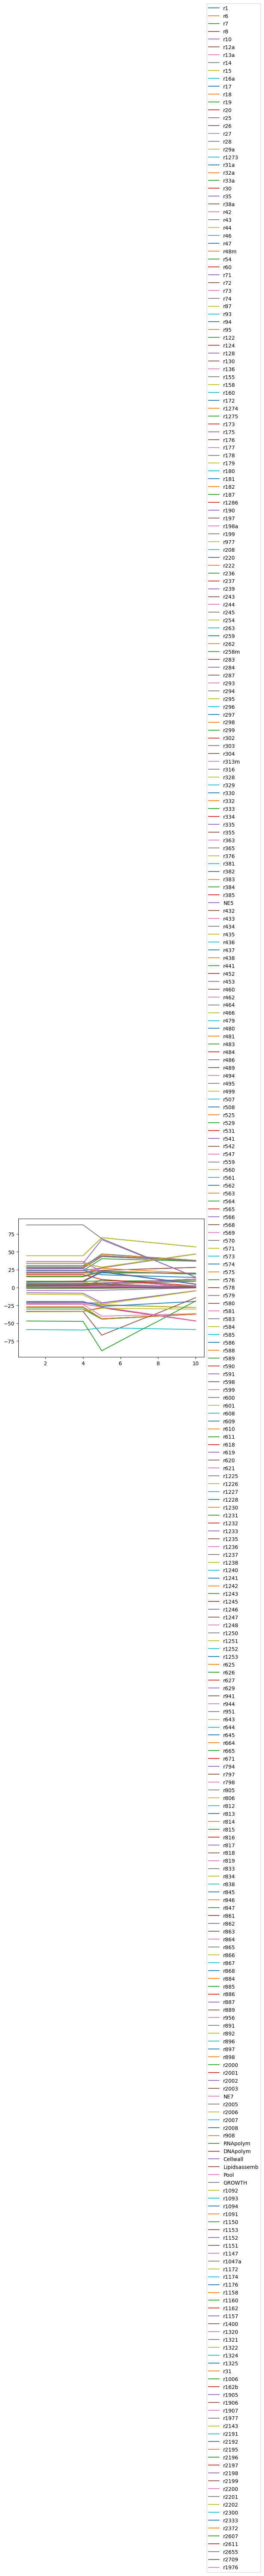

In [319]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To get a better overview of the results we can sort the values and remove all the ones that have a flux change of 0.0

In [320]:
# sorting the dataframe
df= df.sort_values([1], ascending = False)
 
from pytest import approx
# removing genes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]
df.head()

,1,2,3,4,5,6,7,8,9,10
r245,87.473615,87.520890,87.568165,87.615440,68.294317,57.512575,46.730833,35.949091,25.167349,14.383623
r14,44.340290,44.340290,44.340290,44.340290,69.662109,67.070315,64.478521,61.886727,59.294933,56.702108
r15,44.340290,44.340290,44.340290,44.340290,69.662109,67.070315,64.478521,61.886727,59.294933,56.702108
r243,36.206517,36.194225,36.181934,36.169642,22.092620,18.604757,15.116895,11.629033,8.141171,4.652667
r244,36.206517,36.194225,36.181934,36.169642,22.092620,18.604757,15.116895,11.629033,8.141171,4.652667


These results show 10 the enzymes that show the highest increase or decrease in flux. The whole dataframe consistes of 95 rows which means 95 reactions have a change of flux. 

To get a better overview of the changes in flux and genes we can plot the in the following way. 

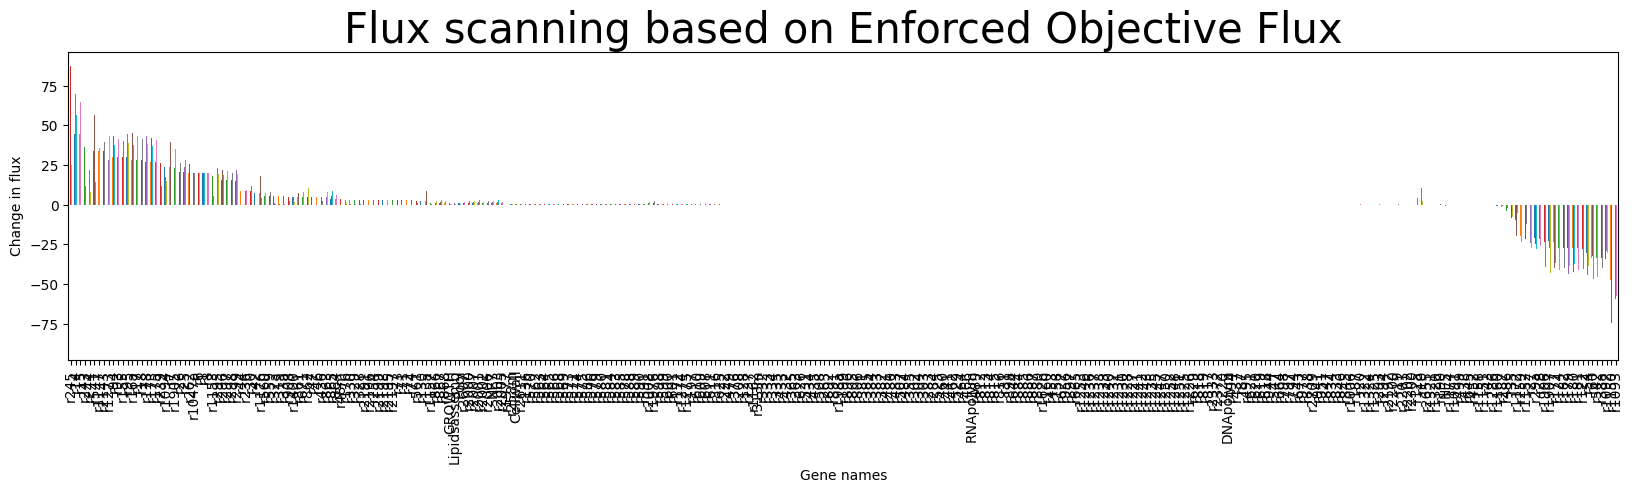

In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def assign_color(val):
    if val >= 0:
        return 'purple'
    else:
        return 'green'

# Assuming df is your pandas DataFrame

# Assuming you have df and it contains the necessary data

fig, ax = plt.subplots(figsize=(20, 4))
df.plot(ax=ax, legend=None, kind='bar', grid=False)

# Applying specific colors to the bars based on the condition
# colors = bar_color(df, "green", "red")
# for i, color in enumerate(colors):
#     for bar in ax.patches[i * len(df.columns): (i + 1) * len(df.columns)]:
#         bar.set_color(color)

ax.set_ylabel('Change in flux')
ax.set_xlabel('Gene names')
ax.set_title('Flux scanning based on Enforced Objective Flux', size=30)
plt.show()


#### We want to see what the relative change is for the different fluxes. This can be calculated like this: R = (B-A) / B +1


In [322]:
df['relative_change_in_flux'] = (df[10]-df[1])/df[10] +1

#### If we look at the reactions that have a higher relative_change_in_flux than 80% we can find target rections. 

In [323]:
target_reactions_df = df[df['relative_change_in_flux'] > 1.8]

In [324]:
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
r2008,0.287117,0.574233,0.861350,1.148467,1.435584,1.722700,2.009817,2.296934,2.584051,2.871167,1.9000
r1976,0.287117,0.574233,0.861350,1.148467,1.435584,1.722700,2.009817,2.296934,2.584051,2.871167,1.9000
r1006,0.000006,0.000006,0.000006,0.000006,0.004000,0.004000,0.004000,0.004000,0.004000,0.004000,1.9985
r187,0.000000,0.000000,0.000000,0.000000,-0.258270,-0.216306,-0.174341,-0.132377,-0.090412,-0.048439,2.0000
r1322,0.000000,0.000000,0.000000,0.000000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0000
r1324,-0.000000,0.000000,0.000000,0.000000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0000
r1325,-0.000000,0.000000,0.000000,0.000000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0000
r293,0.000000,0.000000,0.000000,0.000000,0.623531,0.521507,0.419483,0.317459,0.215435,0.113390,2.0000
r294,0.000000,0.000000,0.000000,0.000000,-0.623531,-0.521507,-0.419483,-0.317459,-0.215435,-0.113390,2.0000
r2192,0.000000,0.000000,0.000000,0.000000,0.005802,0.004852,0.003903,0.002954,0.002005,0.001055,2.0000


In [325]:
df = target_reactions_df.drop(labels='relative_change_in_flux', axis=1)

Text(0.5, 1.0, 'Reactions with a relative change in Flux > 80%')

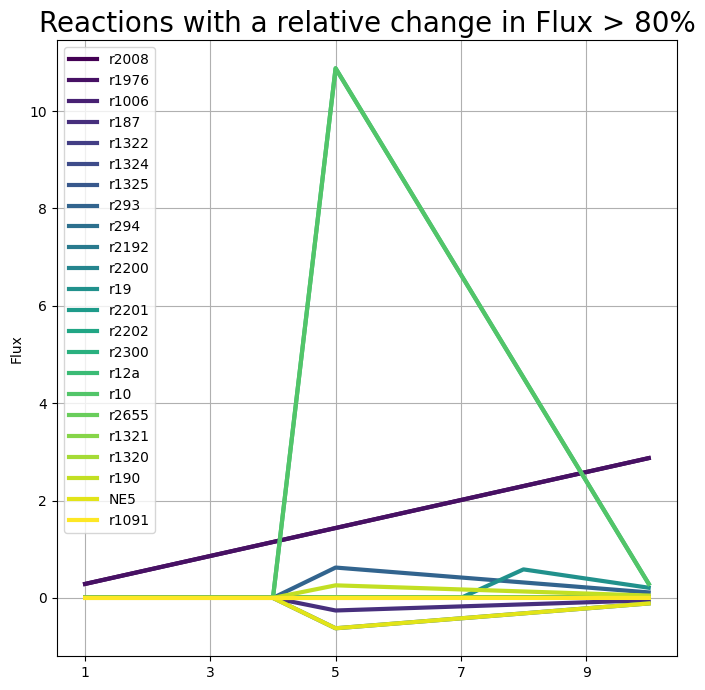

In [326]:
fig = df.T.plot(cmap="viridis",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Reactions with a relative change in Flux > 80%', size=20)

What we see here is that many of the reactions have the same relative change in flux. This is probably due to them being linked to eachother in the model.

In [327]:
#lowest flux reactions
target_reactions_df.tail(10)

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
r2202,0.00000,0.00000,0.00000,0.00000,0.005802,0.004852,0.003903,0.002954,0.002005,0.001055,2.0
r2300,0.00000,0.00000,0.00000,0.00000,0.005802,0.004852,0.003903,0.002954,0.002005,0.001055,2.0
r12a,0.00000,0.00000,0.00000,0.00000,10.877186,8.759496,6.641805,4.524115,2.406424,0.288736,2.0
r10,0.00000,0.00000,0.00000,0.00000,10.877186,8.759496,6.641805,4.524115,2.406424,0.288736,2.0
r2655,-0.00000,0.00000,0.00000,0.00000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0
r1321,0.00000,0.00000,0.00000,0.00000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0
r1320,-0.00000,0.00000,0.00000,0.00000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0
r190,0.00000,0.00000,0.00000,0.00000,0.258270,0.216306,0.174341,0.132377,0.090412,0.048439,2.0
NE5,0.00000,0.00000,0.00000,0.00000,-0.623531,-0.521507,-0.419483,-0.317459,-0.215435,-0.113390,2.0
r1091,-0.00174,-0.00174,-0.00174,-0.00174,-0.001607,-0.001213,-0.000819,-0.000426,-0.000032,0.000000,inf


In [328]:
#higest flux reactions
target_reactions_df.head(20)

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
r2008,0.287117,0.574233,0.861350,1.148467,1.435584,1.722700,2.009817,2.296934,2.584051,2.871167,1.9000
r1976,0.287117,0.574233,0.861350,1.148467,1.435584,1.722700,2.009817,2.296934,2.584051,2.871167,1.9000
r1006,0.000006,0.000006,0.000006,0.000006,0.004000,0.004000,0.004000,0.004000,0.004000,0.004000,1.9985
r187,0.000000,0.000000,0.000000,0.000000,-0.258270,-0.216306,-0.174341,-0.132377,-0.090412,-0.048439,2.0000
r1322,0.000000,0.000000,0.000000,0.000000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0000
r1324,-0.000000,0.000000,0.000000,0.000000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0000
r1325,-0.000000,0.000000,0.000000,0.000000,0.003994,0.003995,0.003996,0.003997,0.003998,0.003999,2.0000
r293,0.000000,0.000000,0.000000,0.000000,0.623531,0.521507,0.419483,0.317459,0.215435,0.113390,2.0000
r294,0.000000,0.000000,0.000000,0.000000,-0.623531,-0.521507,-0.419483,-0.317459,-0.215435,-0.113390,2.0000
r2192,0.000000,0.000000,0.000000,0.000000,0.005802,0.004852,0.003903,0.002954,0.002005,0.001055,2.0000


In [329]:
model.reactions.r12a


Reaction identifier,r12a
Name,Fructose-bisphosphate aldolase
Memory address,0x1fc72e4a430
Stoichiometry,"FDP <=> T3P1 + T3P2 beta-D-Fructose 1,6-bisphosphate <=> D-Glyceraldehyde 3-phosphate + Glycerone phosphate"
GPR,1145051
Lower bound,-1000.0
Upper bound,1000.0


### Top 5 targets for upregulation: 

| Reaction ID | Description                                   | Catalytic reaction                                   |
|-------------|-----------------------------------------------|-----------------------------------------------|
| r2008       | Yanuthone E synthesis                         | Production of yanuthone E but no production of yanuthone D in yanF deletion strain                          |
| r1976       | Yanuthone D transport                         | Transport reaction of yanuthone D from intercellular to extracellular environment                         |
| r1006       | Inositol transport                            | Transport reaction of myo-Inositol between intercellular and extracellular environment                         |
| r187        | Mannitol-1-phosphate 5-dehydrogenase          | The two substrates of this enzyme are D-mannitol 1-phosphate and NAD+, whereas its 3 products are fructose 6-phosphate, NADH and H+                         |
| r1322       | 2-keto-l-gulonate reductase                   | Convert 2-keto-l-gulonate to l-idonate in the presence of either NADH or NADPH	                         |




### Top 5 targets for downregulation: 

| Reaction ID | Description                                   | Catalytic reaction                                   |
|-------------|-----------------------------------------------|-----------------------------------------------|
| r2202       | 2-methylacetoacetyl-CoA thiolase                        | Thiolases form a ubiquitous family of enzymes found in both prokaryotes and eukaryotes. Thiolases catalyse the reversible two step cleavage of acyl-CoA into CoA and acetyl-CoA.                          |
| r2300       | 3-hydroxy-2-methylbutyryl-CoA dehydrogenase                       | Convert of (2S,3S)-3-hydroxy-2-methylbutanoyl-CoA into 2-methyl-3-oxobutanoyl-CoA, accompanied by the transfer of electrons from NAD⁺ to form NADH, releasing a hydrogen ion (H⁺) in the process.                         |
| r12a       | Fructose-bisphosphate aldolase                            | In gluconeogenesis, they catalyse the aldol condensation of a ketose, dihydroxyacetone phosphate (DHAP) and an aldose, glyceraldehyde 3-phosphate (G3P) to form the acylic form of fructose 1,6-bisphosphate (FBP). In glycolysis, they catalyse the reverse cleavage reaction.                         |
| r10        | Pantoate-B-alanine ligase         | Catalyses the ATP-dependent condensation between pantoate and beta-alanine to form pantothenate. This is the last step in the biosynthesis of pantothenate, which is required for CoA synthesis.                       |
| r2655       | Inositol oxygenase                  | Oxidize myo-inositol by molecular oxygen (O2) to produce D-glucuronate, accompanied by the release of a hydrogen ion (H⁺) and water (H2O).                      |


### Summary
?


